In [1]:
%matplotlib inline

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from matplotlib import style
from pandas_datareader import data
import random
from SALib.sample import latin
from functions.stylizedfacts import *
import scipy.stats as stats
from functions.evolutionaryalgo import *
from pandas_datareader import data
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns
import json

In [62]:
style.use('seaborn')

In [2]:
style.available

['seaborn-darkgrid',
 'Solarize_Light2',
 'seaborn-notebook',
 'classic',
 'seaborn-ticks',
 'grayscale',
 'bmh',
 'seaborn-talk',
 'dark_background',
 'ggplot',
 'fivethirtyeight',
 '_classic_test',
 'seaborn-colorblind',
 'seaborn-deep',
 'seaborn-whitegrid',
 'seaborn-bright',
 'seaborn-poster',
 'seaborn-muted',
 'seaborn-paper',
 'seaborn-white',
 'fast',
 'seaborn-pastel',
 'seaborn-dark',
 'tableau-colorblind10',
 'seaborn',
 'seaborn-dark-palette']

# Estimate model
Following the procedure presented by [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802).

## 1 Get data

### a On returns 

In [105]:
start_date = '2008-01-01' #1933
end_date = '2018-08-16'

spy_nom_price = data.DataReader("SP500", 
                       start=start_date, 
                       end=end_date, 
                       data_source='fred')["SP500"].dropna()
spy_nom_returns = spy_nom_price.pct_change()[1:]

### b On fundamentals

In [106]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]

In [107]:
schul_data = pd.read_excel('http://www.macrohistory.net/JST/JSTmoneyR3.xlsx', sheet_name='Data')[['year', 'country', 'stir']]
schul_data = schul_data.loc[(schul_data.country == 'USA')]
schul_data = schul_data.iloc[1:]
schul_data = schul_data.set_index('year')

Extend Schularick annual data to monthly data. 

In [108]:
schul_data['stir']

short_term_int = []
counter = -1
for idx in range(len(shiller_data)):
    if idx % 12 == 0:
        counter += 1
    try:
        short_term_int.append(schul_data['stir'].iloc[counter])
    except:
        pass

In [109]:
discount_rates = np.array(short_term_int) + 5.2 # Discount rate = short-term interest rate + discount rate as estimated by
discount_rates = pd.Series(discount_rates).apply(div_by_hundred)

In [110]:
long_int = shiller_data['Rate GS10'].apply(div_by_hundred)
current_index = 0
final_index = len(shiller_data['Dividend'])
discounted_cash_flows = shiller_data['Dividend'] / ((1 + long_int)**range(current_index, final_index))

Calculate the fundamental value

In [111]:
fundamental_values = []
for idx, cf in enumerate(shiller_data['Dividend'][:-18]):
    next_period_divs = shiller_data['Dividend'][idx+1:]
    next_period_ints = discount_rates[idx+1]
    npv = calculate_npv(next_period_divs, next_period_ints)
    if not np.isnan(npv):
        fundamental_values.append(npv)
    else:
        break

In [112]:
real_prices = shiller_data['Price'][:len(fundamental_values)]

Calculate co-integration of market price with fundamentals.

In [113]:
def cointegr(fundament, price):
    """
    Calculate cointegration with fundamentals
    Return ADF test statistic, ADF critical values 
    """
    model = sm.OLS(fundament, price)
    res = model.fit()
    residuals = res.resid
    cadf = ts.adfuller(residuals)
    return cadf[0], cadf[4]

In [114]:
cointegr(fundamental_values, real_prices)

(-3.3959480557819552,
 {'1%': -3.4343955209592241,
  '10%': -2.5677212878453477,
  '5%': -2.8633268625511046})

In [115]:
model = sm.OLS(fundamental_values, shiller_data['Price'][:len(fundamental_values)])
res = model.fit()
residuals = res.resid

In [116]:
cadf = ts.adfuller(residuals) # can be rejected at 5%
print('ADF test statistic ', cadf[0])
print('ADF critical values', cadf[4])

('ADF test statistic ', -3.3959480557819552)
('ADF critical values', {'5%': -2.8633268625511046, '1%': -3.4343955209592241, '10%': -2.5677212878453477})


In [117]:
ts.adfuller(residuals[:800])[0]

-3.2114422942213952

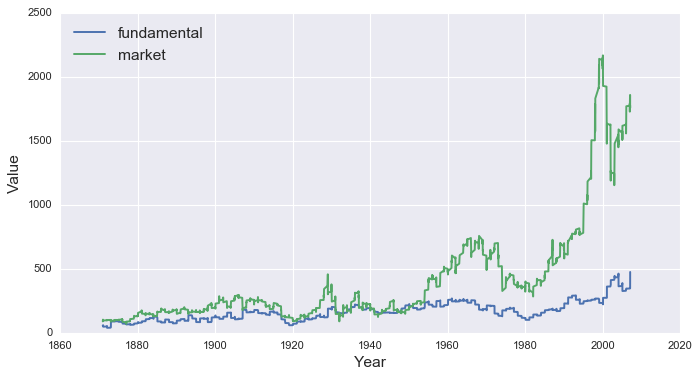

In [118]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

time=0

ax1.plot(shiller_data['Date'][time:len(fundamental_values)], fundamental_values[time:], label='fundamental')
ax1.plot(shiller_data['Date'][time:len(fundamental_values)], shiller_data['Price'][time:len(fundamental_values)], label='market')

ax1.set_ylabel('Value', fontsize='14')
ax1.set_xlabel('Year', fontsize='14')

ax1.legend(fontsize='14', loc='best')
fig.savefig('shiller_campbell_sp500.png')

## 2 Bootstrap data in three blocks

In [119]:
len(spy_nom_returns) / 625.0

4.0128

In [120]:
small_block_size = 250 # 250
large_block_size = 625 # 750
shiller_block_size = 205

**Small data blocks returns**
For short term moments, I produce a bootstrapped series of 250 day (= 1 year) data blocks. This means that there are 25 unique blocks. 

In [121]:
small_data_blocks = []
for x in range(0, len(spy_nom_returns), small_block_size):
    small_data_blocks.append(list(spy_nom_returns[x:x+small_block_size]))
    
# draw 5000 random series
bootstrapped_small_series = []
for i in range(5000):
    sim_data = [random.choice(small_data_blocks) for _ in small_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_small_series.append(sim_data2)

**Large data blocks returns**

For the longer moments, I produce a bootstrapped series of data blocks of 750 days. To accomodate this, I cut the data set with 250 observations, to 6000 observations. 

In [122]:
large_data_blocks = []
for x in range(0, len(spy_nom_returns), large_block_size): # used to be len(spy_nom_returns[:-250])
    large_data_blocks.append(list(spy_nom_returns[x:x+large_block_size]))
    
# draw 5000 random series
bootstrapped_long_series = []
for i in range(5000):
    sim_data = [random.choice(large_data_blocks) for _ in large_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_long_series.append(sim_data2)

**Fundamentals data blocks**

For the deviation from fundamentals, I bootstrap the returns of both the fundamental value and the associated returns for market prices. I divided these into blocks. Then, I bootstrap these blocks of returns into new time series and apply them to the starting values of the fundamental value and real prices. This results in 5000 hypothetical time series of fundamentals and real prices. 

In [123]:
# calculate returns for both
fundamental_returns = pd.Series(fundamental_values).pct_change()[1:]
real_prices_returns = pd.Series(real_prices).pct_change()[1:]

In [124]:
def hypothetical_series(starting_value, returns):
    """
    input: starting_value: float starting value
    input: returns: list 
    """
    returns = list(returns)
    simulated_series = [starting_value]
    for idx in range(len(returns)):
        simulated_series.append(simulated_series[-1] * (1 + returns[idx]))
    return simulated_series

In [125]:
# divide both fundamental returns and price returns into blocks
shiller_data_blocks = []
for x in range(0, len(fundamental_returns[:-3]), shiller_block_size):
    shiller_data_blocks.append((list(fundamental_returns[x:x+shiller_block_size]), list(real_prices_returns[x:x+shiller_block_size])))

In [126]:
# draw 5000 random series 
bootstrapped_shiller_series = []
for i in range(5000):
    #print(i)
    # first sample the data
    sim_data = [random.choice(shiller_data_blocks) for _ in shiller_data_blocks] # choose a random set of blocks
    sim_data_fundamental_returns = [pair[0] for pair in sim_data]
    sim_data_price_returns = [pair[1] for pair in sim_data]
    
    # merge the list of lists
    sim_data_fundamental_returns1 = [item for sublist in sim_data_fundamental_returns for item in sublist]
    sim_data_price_returns1 = [item for sublist in sim_data_price_returns for item in sublist]
    
    # calculate the new time_series
    sim_data_fundamentals = hypothetical_series(fundamental_values[0], sim_data_fundamental_returns1)
    sim_data_prices = hypothetical_series(real_prices[0], sim_data_price_returns1)
    
    bootstrapped_shiller_series.append((sim_data_fundamentals, sim_data_prices))

## 3 Choose moments

For returns, I use the following moments **short-term moments**: 

1. mean first-order autocorrelation of the raw returns (no predictability),
2. autocorrelations at lags t ¼ 1
3. autocorrelations at lags t ¼ 5
4. mean first-order autocorrelation of the of the absolute returns (volatility clustering),
5. Kurtosis (fat tails), 

In [127]:
first_order_autocors = []
mean_abs_autocor = []
autocors1 = []
autocors5 = []
kurtoses = []
for rets in bootstrapped_small_series:
    first_order_autocors.append(autocorrelation_returns(rets, 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(rets, 25))
    rets = pd.Series(rets)
    autocors1.append(rets.autocorr(lag=1))
    autocors5.append(rets.autocorr(lag=5))
    kurtoses.append(kurtosis(rets))

For long-term moments, I use the autocorrelation of returns for the with lags (10, 25, 50, 100).

In [128]:
spy_abs_auto10 = []
spy_abs_auto25 = []
spy_abs_auto50 = []
spy_abs_auto100 = []

for rets in bootstrapped_long_series:
    rets = pd.Series(rets)
    spy_abs_auto10.append(rets.abs().autocorr(lag=10))
    spy_abs_auto25.append(rets.abs().autocorr(lag=25))
    spy_abs_auto50.append(rets.abs().autocorr(lag=50))
    spy_abs_auto100.append(rets.abs().autocorr(lag=100))

For deviations from fundamentals, I use the AFD t-score to test for mean-reversion in the relationship between fundamentals and the price.

In [129]:
cointegrations = []

for sers in bootstrapped_shiller_series:
    cointegrations.append(cointegr(sers[0], sers[1])[0])

## 4 Plot moments

In [130]:
# Get the t-critical value*
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

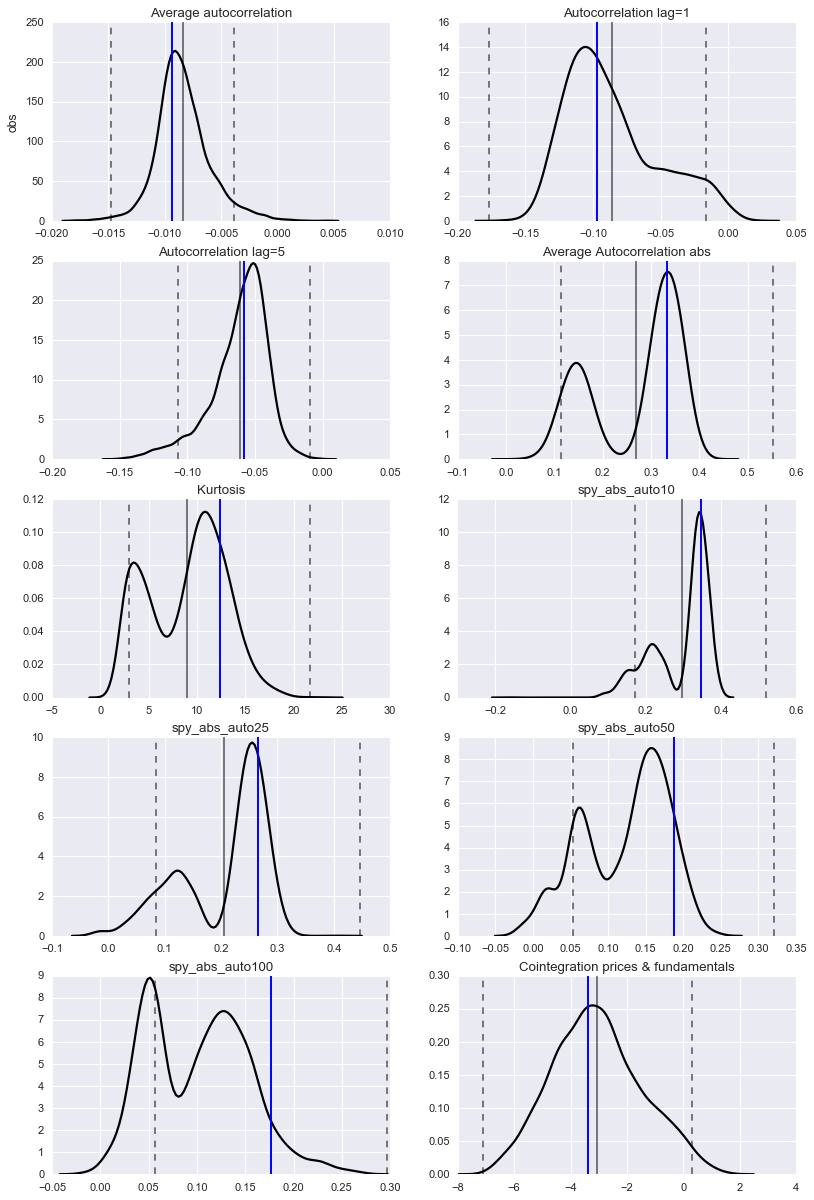

In [131]:
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6) , (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(12,18))

# 1 mean autocor
sns.distplot(first_order_autocors, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1)

for xc in confidence_interval(first_order_autocors, autocorrelation_returns(spy_nom_returns, 25)):
    ax1.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax1.axvline(x=np.mean(first_order_autocors), color='k', alpha=0.5)
ax1.axvline(x=autocorrelation_returns(spy_nom_returns, 25))

ax1.set_ylabel('obs')
ax1.set_title('Average autocorrelation')

# 2 autocorr lag 1 
sns.distplot(autocors1, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax2)
ax2.set_title('Autocorrelation lag=1')

for xc in confidence_interval(autocors1, spy_nom_returns.autocorr(lag=1)):
    ax2.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax2.axvline(x=np.mean(autocors1), color='k', alpha=0.5)
ax2.axvline(x=spy_nom_returns.autocorr(lag=1))

# 3 autocorr lag 1 
sns.distplot(autocors5, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax3)
ax3.set_title('Autocorrelation lag=5')

for xc in confidence_interval(autocors5, spy_nom_returns.autocorr(lag=5)):
    ax3.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax3.axvline(x=np.mean(autocors5), color='k', alpha=0.5)
ax3.axvline(x=spy_nom_returns.autocorr(lag=5))

# 4 mean abs autocor
sns.distplot(mean_abs_autocor, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax4)

for xc in confidence_interval(mean_abs_autocor, autocorrelation_abs_returns(spy_nom_returns, 25)):
    ax4.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax4.axvline(x=np.mean(mean_abs_autocor), color='k', alpha=0.5)
ax4.axvline(x=autocorrelation_abs_returns(spy_nom_returns, 25))

ax4.set_title('Average Autocorrelation abs')

# 5 kurtosis
sns.distplot(kurtoses, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax5)

for xc in confidence_interval(kurtoses, kurtosis(spy_nom_returns)):
    ax5.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax5.axvline(x=np.mean(kurtoses), color='k', alpha=0.5)
ax5.axvline(x=kurtosis(spy_nom_returns))

ax5.set_title('Kurtosis')

# 6 AC abs long 10
sns.distplot(spy_abs_auto10, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax6)

for xc in confidence_interval(spy_abs_auto10, spy_nom_returns.abs().autocorr(lag=10)):
    ax6.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax6.axvline(x=np.mean(spy_abs_auto10), color='k', alpha=0.5)
ax6.axvline(x=spy_nom_returns.abs().autocorr(lag=10))

ax6.set_title('spy_abs_auto10')

# 7 AC abs long 25
sns.distplot(spy_abs_auto25, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax7)

for xc in confidence_interval(spy_abs_auto25, spy_nom_returns.abs().autocorr(lag=25)):
    ax7.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax7.axvline(x=np.mean(spy_abs_auto25), color='k', alpha=0.5)
ax7.axvline(x=spy_nom_returns.abs().autocorr(lag=25))

ax7.set_title('spy_abs_auto25')

# 8 AC abs long 50
sns.distplot(spy_abs_auto50, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax8)

for xc in confidence_interval(spy_abs_auto50, spy_nom_returns.abs().autocorr(lag=50)):
    ax8.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax8.axvline(x=np.mean(spy_abs_auto50), color='k', alpha=0.5)
ax8.axvline(x=spy_nom_returns.abs().autocorr(lag=50))

ax8.set_title('spy_abs_auto50')

# 9 AC abs long 100
sns.distplot(spy_abs_auto100, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax9)

for xc in confidence_interval(spy_abs_auto100, spy_nom_returns.abs().autocorr(lag=100)):
    ax9.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax9.axvline(x=np.mean(spy_abs_auto100), color='k', alpha=0.5)
ax9.axvline(x=spy_nom_returns.abs().autocorr(lag=100))

ax9.set_title('spy_abs_auto100')

# 10 Deviation from fundamentals
sns.distplot(cointegrations, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax10)

for xc in confidence_interval(cointegrations, cointegr(fundamental_values, real_prices)[0]):
    ax10.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax10.axvline(x=np.mean(cointegrations), color='k', alpha=0.5)
ax10.axvline(x=cointegr(fundamental_values, real_prices)[0])

ax10.set_title('Cointegration prices & fundamentals')

fig.savefig('moments.png')

## 5 Estimate weighting matrix:

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [132]:
emp_moments = np.array([
        autocorrelation_returns(spy_nom_returns, 25),
        spy_nom_returns.autocorr(lag=1),
        spy_nom_returns.autocorr(lag=5),
        autocorrelation_abs_returns(spy_nom_returns, 25),
        kurtosis(spy_nom_returns),
        spy_nom_returns.abs().autocorr(lag=10),
        spy_nom_returns.abs().autocorr(lag=25),
        spy_nom_returns.abs().autocorr(lag=50),
        spy_nom_returns.abs().autocorr(lag=100),
        cointegr(fundamental_values, real_prices)[0]
    ])

In [133]:
emp_moments

array([ -9.30779653e-03,  -9.67183591e-02,  -5.82127566e-02,
         3.33043601e-01,   1.23406758e+01,   3.46105323e-01,
         2.65993289e-01,   1.87197386e-01,   1.76927495e-01,
        -3.39594806e+00])

In [161]:
spy_abs_auto50 = list(pd.Series(spy_abs_auto50).fillna(0))
spy_abs_auto100 = list(pd.Series(spy_abs_auto100).fillna(0))

In [162]:
all_bootstrapped_moments = [first_order_autocors,
                            autocors1,
                            autocors5,
                            mean_abs_autocor,
                            kurtoses,
                            spy_abs_auto10,
                            spy_abs_auto25,
                            spy_abs_auto50,
                            spy_abs_auto100,
                            cointegrations
                           ]

In [163]:
# export conrfidence intervals of bootstrapped data
with open('all_bootstrapped_moments.json', 'w') as fp:
    json.dump(all_bootstrapped_moments, fp)

In [164]:
av_moments = [np.mean(x) for x in all_bootstrapped_moments]

In [165]:
def get_specific_bootstraps_moments(full_series, bootstrap_number):
    """Get a vector with the moments of a specific bootstrap"""
    return np.array([full_series[i][bootstrap_number] for i in range(len(full_series))])

In [166]:
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_long_series))]

Then, I estimate the moment covariance matrix of the bootstrapped data as: 

$\hat{W} = \frac{1}{B} \sum{(m^b - \hat{m})(m^b - \hat{m})'}$

In [167]:
W_hat = 1.0 / len(bootstrapped_long_series) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])

And take the inverse so that 

$W = \hat{W}^{-1}$

In [168]:
W = np.linalg.inv(W_hat)

In [169]:
W

array([[  2.56620727e+05,   1.19291564e+04,  -5.62679180e+03,
          6.54975239e+03,  -3.91198702e+01,  -2.66832323e+02,
         -7.34011427e+01,   1.19887987e+03,  -9.72133289e+02,
         -1.26176761e+00],
       [  1.19291564e+04,   3.18748783e+03,  -2.02082808e+03,
          8.92371759e+02,   5.04256318e+00,  -2.22572583e+01,
         -2.23540578e+01,   1.26016648e+02,  -1.04919132e+02,
         -3.27170161e-01],
       [ -5.62679180e+03,  -2.02082808e+03,   4.14247418e+03,
         -9.75387005e+02,   1.63364168e+00,   1.75657398e+02,
         -1.27049520e+02,  -1.54358185e+02,   1.27033661e+02,
          7.77295212e-01],
       [  6.54975239e+03,   8.92371759e+02,  -9.75387005e+02,
          7.01106322e+02,  -6.68191933e+00,  -4.89145175e+01,
          2.42089101e+01,   8.44110668e+01,  -6.30400736e+01,
         -5.46213383e-01],
       [ -3.91198702e+01,   5.04256318e+00,   1.63364168e+00,
         -6.68191933e+00,   2.17467347e-01,   6.14418120e-01,
         -5.17791244e-01

The confidence intervals are: 

In [171]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [172]:
# export conrfidence intervals of bootstrapped data
with open('bootstrapped_confidence_intervals.json', 'w') as fp:
    json.dump(confidence_intervals, fp)

Then, I apply the cost function to the bootstrapped series to get a distribution of J-values

In [173]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

In [174]:
# export J-values of bootstrapped data
with open('bootstrapped_j_values.json', 'w') as fp:
    json.dump(j_values, fp)

## 6 Estimate model

To estimate the model parameters, I employ the traditional approach for the method of simulated moments by minimizing the quadtratic loss function: 

$J = J(m) = (m^{sim} - m^{emp})' W (m^{sim} - m^{emp}) $

The first term is the transpose of the difference between simulated and actual moments. The seond term is the weighting matrix. The third term is the difference between simulated and empirical moments. 


To reduce the sample variability in the stochastic simulations, I choose a time horizon (following [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802)) of 10 times the empirical time series. In this case the longest time series. 

In [213]:
len(spy_nom_returns)

2500

In [214]:
simulation_time = max(len(spy_nom_returns), len(fundamental_values)) * 10
simulation_time

25000

### 6.1 Set parameter bounds

Table 1 shows the parameter bounds, free parameters are **bold**. 

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| ticks       | 2000, 2000, 0   |
| fundamental_value       | 100, 100, 0      |
| **n_traders**       | 100, 5000, 25      |
| **trader_sample_size**       | 1, 100, 10      |
| **std_fundamental**       | 0.01, 0.2 , 0.01     |
| **std_noise**       | 0.01, 0.35, 0.01      |
| **std_vol**       | 1, 50, 1      |
| max_order_expiration_ticks       | 5, 200, 5       |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **w_random**       | 0.0, 100.0, 1.0      |
| **w_mean_reversion**       | 0.0, 100.0, 1.0       |
| spread_max       | 0.01, 0.15, 0.01       |
| **horizon_min**       | 1, 8, 1      |
| **horizon_max**       | 9, 30, 1      |
*Table 1 Parameter bounds*

In [215]:
problem = {
  'num_vars': 8,
  'names': ['trader_sample_size', 'std_noise', 
            'std_vol', 'w_fundamentalists', 'w_momentum',
           'w_random', 'w_mean_reversion',
           'horizon_max'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [1, 20], [0.0, 100.0], [0.0, 100.0], 
             [1.0, 100.0], [0.0, 100.0],
             [9, 30]]
}

### 6.2 Sample parameter space
For the initial population of parameters, I use a Latin Hypercube procedure to sample the parameter space.

In [216]:
population_size = 100

In [217]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

Transform some of the parameters to integers:

In [218]:
for idx, parameters in enumerate(latin_hyper_cube):
    # ints: 0, 2, 7
    latin_hyper_cube[idx][0] = int(latin_hyper_cube[idx][0])
    latin_hyper_cube[idx][2] = int(latin_hyper_cube[idx][2])
    latin_hyper_cube[idx][7] = int(latin_hyper_cube[idx][7])

### 6.3 Creat initial population for evolutionary algorithm

In [219]:
population = []
for parameters in latin_hyper_cube:
    pars = {}
    for key, value in zip(problem['names'], parameters):
        pars[key] = value
    population.append(Individual(pars, [], np.inf))
all_populations = [population]
av_pop_fitness = []

### 6.4 Determine fixed parameters

In [220]:
start_fundamental_value = int(np.mean(fundamental_values))
std_fundamental_value = np.std(pd.Series(fundamental_values).pct_change())
burn_in_period = 100 
ticks = simulation_time

In [221]:
print('start_fundamental_value: ', start_fundamental_value)
print('std_fundamental_value: ', std_fundamental_value)

('start_fundamental_value: ', 166)
('std_fundamental_value: ', 0.0530163128919286)


In [60]:
fixed_parameters = {"ticks": 1000, "fundamental_value": start_fundamental_value,
                    'n_traders': 1000, 'std_fundamental': std_fundamental_value, 'spread_max': 0.004087, 
                    'max_order_expiration_ticks': 30}
iterations = 10
NRUNS = 2

### 6.5 Optimization via evolutionary algorithm

In [50]:
ticks

62500

In [74]:
for generation in range(iterations):
    # simulate every population
    simulated_population, fitness = simulate_population_msm(all_populations[generation], NRUNS, 
                                                            fixed_parameters, emp_moments, W)
    # record population fitness
    av_pop_fitness.append(fitness)
    print('generation: ', generation, 'fitness: ', fitness)
    # add a new, evolved population to the list of populations
    all_populations.append(evolve_population(simulated_population, fittest_to_retain=0.3, random_to_retain=0.2, 
                                             parents_to_mutate=0.3, parameters_to_mutate=0.1, problem=problem))

generation:  0 fitness:  inf
generation:  1 fitness:  inf
generation:  2 fitness:  inf
generation:  3 fitness:  inf
generation:  4 fitness:  inf
generation:  5 fitness:  inf
generation:  6 fitness:  inf
generation:  7 fitness:  inf
generation:  8 fitness:  inf
generation:  9 fitness:  inf


C:\Users\p267237\Documents\GitHub\sim-fin-abm\simfinmodel.py:22: RuntimeWarning: invalid value encountered in log
  fundamental_component = np.log(fundamental[-1] / mid_price)


## 7 Extract estimated parameters

In [77]:
parameters = all_populations[-1][0].parameters.copy()
params = fixed_parameters.copy()
params.update(parameters)
params

{'fundamental_value': 166,
 'horizon_max': 26,
 'horizon_min': 4,
 'max_order_expiration_ticks': 30,
 'n_traders': 1000,
 'spread_max': 0.085,
 'std_fundamental': 75.095292914798279,
 'std_noise': 0.22288355857120595,
 'std_vol': 15,
 'ticks': 1000,
 'trader_sample_size': 13,
 'w_buy_hold': 0.0,
 'w_fundamentalists': 0.3462431169548886,
 'w_mean_reversion': 51.91903909974683,
 'w_momentum': 93.36914240676776,
 'w_random': 40.29170063409717}

In [81]:
with open('estimated_parameters.json', 'w') as fp:
    json.dump(params, fp, sort_keys=True, indent=4)

## Best stylized facts compared to actual stylized facts

In [79]:
print('simulation:')
print(all_populations[-1][0].stylized_facts)
print('s&p500:')
print(emp_moments)

simulation:
[ -1.78448880e-02  -1.30219561e-01   1.62535933e-02   8.47394797e-02
   9.88039218e+00   7.33208104e-02   7.19942715e-02   3.15658113e-02
   8.12587763e-03  -2.08421970e+00]
s&p500:
[ -8.31204465e-03  -6.37216343e-02  -4.00930616e-02   2.60637329e-01
   1.12024156e+01   2.86882774e-01   2.12984694e-01   1.68871832e-01
   1.33350570e-01  -3.39594806e+00]


## 8 Estimate non-mean reversion model for comparison

In [82]:
problem_no_mean_reversion = {
  'num_vars': 7,
  'names': ['trader_sample_size', 'std_noise',
            'std_vol', 'w_fundamentalists', 'w_momentum',
           'w_random', 'horizon_max'],
  'bounds': [[1, 30], [0.05, 0.30],
             [1, 20], [0.0, 100.0], [0.0, 100.0],
             [1.0, 100.0], [9, 30]]
}

In [84]:
hyper_cube_no_mean_reversion = latin.sample(problem=problem_no_mean_reversion, N=population_size)
hyper_cube_no_mean_reversion = hyper_cube_no_mean_reversion.tolist()

In [85]:
for idx, parameters in enumerate(hyper_cube_no_mean_reversion):
    # ints: 0, 2, 6, 7
    hyper_cube_no_mean_reversion[idx][0] = int(hyper_cube_no_mean_reversion[idx][0])
    hyper_cube_no_mean_reversion[idx][2] = int(hyper_cube_no_mean_reversion[idx][2])
    hyper_cube_no_mean_reversion[idx][6] = int(hyper_cube_no_mean_reversion[idx][6])

In [86]:
# create initial population model no-mean reversion
population_no_mean_reversion = []
for parameters in hyper_cube_no_mean_reversion:
    pars = {}
    for key, value in zip(problem_no_mean_reversion['names'], parameters):
        pars[key] = value
    population_no_mean_reversion.append(Individual(pars, [], np.inf))
all_populations_no_mean_reversion = [population_no_mean_reversion]
av_pop_fitness_no_mean_reversion = []

In [87]:
fixed_parameters_no_mean_reversion = {"ticks": 1000, "fundamental_value": start_fundamental_value, 
                                      'n_traders': 1000, 'std_fundamental': std_fundamental_value, 'spread_max': 0.004087, 
                                      "w_mean_reversion": 0.0, 'max_order_expiration_ticks': 30}

In [89]:
for generation in range(iterations):
    # simulate every population
    simulated_population, fitness = simulate_population_msm(all_populations_no_mean_reversion[generation], NRUNS, 
                                                            fixed_parameters_no_mean_reversion, emp_moments, W)
    # record population fitness
    av_pop_fitness_no_mean_reversion.append(fitness)
    print('generation: ', generation, 'fitness: ', fitness)
    # add a new, evolved population to the list of populations
    all_populations_no_mean_reversion.append(evolve_population(simulated_population, fittest_to_retain=0.3, random_to_retain=0.2, 
                                             parents_to_mutate=0.3, parameters_to_mutate=0.1, problem=problem_no_mean_reversion))

generation:  0 fitness:  inf
generation:  1 fitness:  inf
generation:  2 fitness:  inf
generation:  3 fitness:  3288.19644757
generation:  4 fitness:  2187.09706437
generation:  5 fitness:  1941.00598128
generation:  6 fitness:  1197.3806789
generation:  7 fitness:  953.800820234
generation:  8 fitness:  885.032999865
generation:  9 fitness:  609.320650424


C:\Users\p267237\Documents\GitHub\sim-fin-abm\simfinmodel.py:22: RuntimeWarning: invalid value encountered in log
  fundamental_component = np.log(fundamental[-1] / mid_price)


## Extract parameters

In [90]:
parameters = all_populations_no_mean_reversion[-1][0].parameters.copy()
params_nm = fixed_parameters.copy()
params_nm.update(parameters)
params_nm

{'fundamental_value': 166,
 'horizon_max': 12,
 'horizon_min': 7,
 'max_order_expiration_ticks': 30,
 'n_traders': 1000,
 'spread_max': 0.085,
 'std_fundamental': 75.095292914798279,
 'std_noise': 0.214139333234597,
 'std_vol': 3,
 'ticks': 1000,
 'trader_sample_size': 1,
 'w_buy_hold': 0.0,
 'w_fundamentalists': 5.812203143339776,
 'w_momentum': 17.70098749983911,
 'w_random': 99.00060709801778}

In [91]:
with open('estimated_parameters_nm.json', 'w') as fp:
    json.dump(params_nm, fp, sort_keys=True, indent=4)

## Best stylized facts compared to actual stylized facts

In [94]:
print('simulation:')
print(all_populations_no_mean_reversion[-1][0].stylized_facts)
print('s&p500:')
print(emp_moments)

simulation:
[ -2.68603798e-03  -5.33667315e-02  -1.99640462e-02   4.37271006e-02
   6.26281888e+00   4.90722735e-02  -2.07969777e-02   2.00071475e-02
   1.16937432e-03  -3.12115526e+00]
s&p500:
[ -8.31204465e-03  -6.37216343e-02  -4.00930616e-02   2.60637329e-01
   1.12024156e+01   2.86882774e-01   2.12984694e-01   1.68871832e-01
   1.33350570e-01  -3.39594806e+00]
